#  Predicting conmute time between counties
### 03/13/2018
### Pedro Armengol


## Set-up

In [42]:
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.functions import *
import numpy as np
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator 
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [2]:
# initialise sparkContext
spark = SparkSession.builder \
    .appName('Miappspark') \
    .config("spark.driver.cores", 2) \
    .config('spark.executor.memory', '5gb') \
    .config("spark.executor.cores", "3") \
    .config("spark.files.maxPartitionBytes", "64mb") \
    .getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)

## Data

### LODES: OD

In [3]:
df = spark.read.format("parquet").load("s3://lsdm-emr-util/lsdm-data/lodes/od/od.parquet")

In [ ]:
df.head(10)

In [ ]:
df.count()

### Driving distances

In [4]:
drive = spark.read.parquet('s3://lsdm-emr-util/lsdm-data/travel-times/drive_times.parquet')

In [ ]:
drive.count()

In [ ]:

drive.distinct().count()

## Cleaning the data

### Sample: to test command (later will be perfomed over the whole dataset)

In [5]:
df_sample = df.sample(False, 1, 25)
df_sample = df_sample.alias('df_sample')

In [6]:
drive_sample = drive.sample(False, 1,25)
drive_sample = drive_sample.alias('drive_sample')

### Trimming w_tract and h_tract to obtain census_track (with join purposes)

In [7]:

df_sample = df_sample.withColumn("w_tract", df.w_geocode.substr(1, 11))

In [8]:
df_sample = df_sample.withColumn("h_tract", df.h_geocode.substr(1, 11))

###  Aggregate at Census Tract level

Create view (inside the sql is not possible to run dataframes, just "views" that play the role of sql tables)

In [9]:
df_sample.createOrReplaceTempView("df_sample_sql")

Create the new dataframe: aggregation (using the view within the sql query)

In [10]:
df_sample_sql = sqlContext.sql("SELECT SUM(s000) as s000, SUM(sa01) as sa01, SUM(sa02) as sa02, SUM(sa03) as sa03, SUM(se01) as se01, SUM(se02) as se02, SUM(se03) as se03, SUM(si01) as si01, SUM(si02) as si02, SUM(si03) as si03, w_tract, h_tract FROM df_sample_sql AS df GROUP BY df.w_tract, df.h_tract")

So far, we have the aggregation of the variables by census tracts (before where in census blocks). There are rows that go from one census tract to another (because before they went between census tract blocks). Those rows are going to be dropped in the inner join with the driving distances.

## JOIN

The previous df_sample, census block, data will be our new, census tract, data.

In [11]:
df_sample = df_sample_sql


In [ ]:
drive_sample.columns

In [12]:
df_join = df_sample.join(drive_sample, (df_sample.h_tract == drive_sample.from_tract) & (df_sample.w_tract == drive_sample.to_tract)).select("*")

### Statistics of the join

In [13]:
df_join.columns

['s000',
 'sa01',
 'sa02',
 'sa03',
 'se01',
 'se02',
 'se03',
 'si01',
 'si02',
 'si03',
 'w_tract',
 'h_tract',
 'from_tract',
 'to_tract',
 'miles',
 'minutes']

In [ ]:
df_join.head(10)

How many tract pairs matched between both datasets. We took samples of 10% in each dataset: LODES (OD) and . Theoretically, we shoud expect a perfect match in the drivers data and f 

## Descriptive Statistics

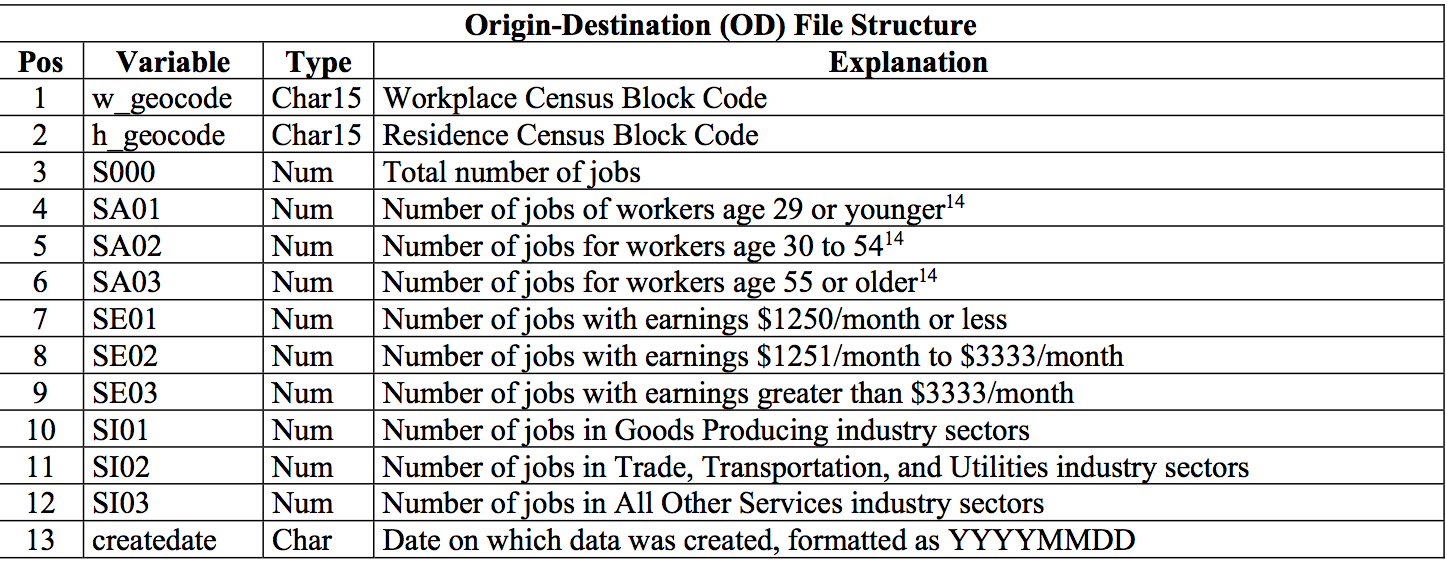

In [ ]:
df_stats = df_join.toPandas()

In [ ]:
np.round(df_stats.describe(), decimals=2)

## Predictions

The objective of the fellowing exercise is to prove if we can predict the conmuting time/distance between a pair of counties using the number of jobs by age, income and type of industry in the county of destination. In other words, what type of jobs determine that people conmute longer distances into the county of interest.

#### Sample for testing predicitons

In [ ]:
df_sample = df_join.sample(False, 0.001, 25)
df_sample = df_sample.alias('df_sample')

### Vectorize the data

#### Label 

Create dummy variable: high distance conmuting

In [14]:
df_join = df_join.withColumn("long_conmute", (when(df_join.miles > 84.50, 1).otherwise(0)))

Rename columns (for processing issues)

In [15]:
df_join = df_join.withColumnRenamed("minutes","label")

In [16]:
stages = []

#### Features

In [20]:
numcols = ["s000","sa01","sa02","sa03","se01","se02","se03","si01","si02","si03"]

In [21]:
assemblerInputs = numcols

In [22]:
assembler = VectorAssembler(inputCols=assemblerInputs,outputCol="features")

In [23]:
stages += [assembler]

#### Pipeline

In [24]:
pipeline = Pipeline(stages=stages)

In [25]:
pipelineModel = pipeline.fit(df_join)

In [27]:
df_join = pipelineModel.transform(df_join)

In [28]:
selectedcols = ["label", "features"] 

In [29]:
dataset = df_join.select(selectedcols)


In [30]:
dataset.head(10)

[Row(label=27.8, features=DenseVector([52.0, 18.0, 26.0, 8.0, 14.0, 31.0, 7.0, 0.0, 3.0, 49.0])),
 Row(label=122.5, features=SparseVector(10, {0: 1.0, 1: 1.0, 5: 1.0, 9: 1.0})),
 Row(label=71.2, features=DenseVector([14.0, 4.0, 7.0, 3.0, 2.0, 8.0, 4.0, 4.0, 1.0, 9.0])),
 Row(label=58.7, features=DenseVector([4.0, 1.0, 3.0, 0.0, 0.0, 1.0, 3.0, 2.0, 1.0, 1.0])),
 Row(label=49.3, features=DenseVector([53.0, 9.0, 39.0, 5.0, 2.0, 8.0, 43.0, 32.0, 19.0, 2.0])),
 Row(label=199.8, features=SparseVector(10, {0: 2.0, 2: 2.0, 4: 1.0, 5: 1.0, 9: 2.0})),
 Row(label=34.1, features=DenseVector([3.0, 1.0, 1.0, 1.0, 3.0, 0.0, 0.0, 0.0, 2.0, 1.0])),
 Row(label=184.2, features=SparseVector(10, {0: 4.0, 2: 2.0, 3: 2.0, 6: 4.0, 9: 4.0})),
 Row(label=61.9, features=SparseVector(10, {0: 1.0, 1: 1.0, 4: 1.0, 8: 1.0})),
 Row(label=126.7, features=SparseVector(10, {0: 1.0, 3: 1.0, 6: 1.0, 7: 1.0}))]

### Training and testing sets

In [32]:
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed = 100)

Number of observations in training set

In [ ]:
print trainingData.count()


Number of observations in testing set

In [107]:
print testData.count()

385806


### Regression Model: Run just one model

In [36]:
lr = LinearRegression(labelCol="label", featuresCol="features", maxIter=10)

In [37]:
lrModel = lr.fit(trainingData)

In [38]:
predictions = lrModel.transform(testData)

In [39]:
predictions.printSchema()

root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- prediction: double (nullable = true)



### Evaluate model (Standard Parameters)

We are going to obtain a couple of metrics to observe the performance of our model: R2 (coefficient of determinations and  the Mean Square Error

In [43]:
evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='label')

#### R2

In [45]:
evaluator.evaluate(predictions, {evaluator.metricName: "r2"})


0.02029905971268986

The model is explaining just 2% of the variation in the model. We are not finding features with enough predicting power over conmuting time (minutes) in this dataset.

#### Root Mean Square Error (RMSE)

In [48]:
evaluator.evaluate(predictions)


65.99835695181815

The root square error is 65.99 minutes between or predictions and the actual values. We don't have other models, yet, to compare this result. However, because the R2 metric of the model was relatively low, I can suggest that this RMSE is relatively high.


### Weights of the features

In [51]:
lrModel.coefficients

DenseVector([-0.0579, -0.5476, -0.1776, 0.6841, 0.1689, -0.0811, -0.4887, 0.1073, -0.425, -0.1055])

By magnitude of the coefficients, this is the explanation for the 3 most important ones:

For each additional job of a worker age 55 or older, the conmmuting time increase by 0.6841 minutes

For each additional job of a worker age 29 or younger the commuting time decrease by 0.5476 minutes

For each additional job of a worker with earnings greater than $3,333.0/month the conmmuting time decrease by 0.4887 minutes

The caveat here is that the statistical significance of the point estimates was not estimate, however, for the amount of observations (>1.5 billions) we can expect statistical significance at 99.9999%.



### Cross-validation Exercise

Fit different models with the parameters of paramGrid (27 models in total) using the training data. Later on, estimate the RMSE Efor each model using the testing data and, lastly, select the model (param set) with the minimum RMSE.

Param Grid

In [52]:
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.0, 0.5, 1.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [1, 5, 10])
             .build())

Estimate the cross Validation model: take model lr (see previous section). Take paramGrid for diffetent combinations. Take the previous defined evaluator (default choice RMSE: see previous section). Take number of folds = 5. K-folds means the splitting of the dataset into k non-overlapping randomly partitioned folds.

In [53]:
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

In [ ]:
cvModel = cv.fit(trainingData)

In [ ]:
predictions = cvModel.transform(testData)

In [ ]:
evaluator.evaluate(predictions)

#### Best model

Select the best model.

First show the intercept of the model

In [ ]:
print 'Model Intercept: ', cvModel.bestModel.intercept

Show the weights of the model

In [ ]:
weights = cvModel.bestModel.weights

In [ ]:
weights = map(lambda w: (float(w),), weights)

In [ ]:
weightsDF = sqlContext.createDataFrame(weights, ["Feature Weight"])

In [ ]:
display(weightsDF)

Show the RMSE of the selected model

In [ ]:
cv.bestModel.rmse


### Interpretation

With U.S Census data about origin and destination (LODES) and with estimates of the Urban Institute of distances (miles and minutes) between counties, I estimated a model to predict the conmuting time between two counties based on information about number of employees by type in the destination county. My estimations included a cross-validation exercise that fitted 27 models with different parameters (different penalization terms: L1, elastic net parameters and iterations for convergence in the loss minimization function) over 5 random splittings of the data (5-fold partitions). After the cross-validation exercise, the model with the smaller Root Mean Squared Error (RMSE) was selected. Three point estimates where particularly interesting:

For each additional job of a worker age 55 or older, the conmmuting time increase by 0.6841 minutes

For each additional job of a worker age 29 or younger the commuting time decrease by 0.5476 minutes

For each additional job of a worker with earnings greater than $3,333.0/month the conmmuting time decrease by 0.4887 minutes

CAVEAT: 
it is important to recall that the previous results are not causal (unbiased) because no identification strategy strategy was followed (probably there are endogeneous variables hiding the real relationship between the three coefficients and the conmuting time). In other words, the previous point estimates should be interpreted as a sort of correlation and not as causal effect.

Finally, just using the total number of workers by age, earnings and type of industry, I was not able to build a highly accurate predictive model. However, with a bigger array of information about counties, infraestructure and the market labour more complex models could be estimated.
